# Problem Description

Consider a household gathering information about $2$ goods whose inflation rates are each determined by an aggregate and a good specific, idiosyncratic shock. As such, in each period $t,$ I take 
\begin{align}
    \pi_{1t} &= q_{t} + z_{1t}, \\
    \pi_{2t} &= q_{t} + z_{2t},
\end{align}
with the aggregate shock, $q,$ and the idiosyncratic shocks, $z_{it},$ evolving according to the $AR(1)$ processes:
\begin{align}
    q_{t} &= \rho q_{t-1} + \epsilon_{1t}, \nonumber \\
    z_{1t} &= \rho z_{1t-1} + \epsilon_{2t}, \nonumber \\
    z_{2t} &= \rho z_{2t-1} + \epsilon_{3t}, \label{eq:process}
\end{align}
where the innovations $\epsilon_{it}$ are independent normally distributed shocks. Specifically, let $\mathbf{x}_{t} = \begin{pmatrix} q_{t} \\ z_{1t} \\ z_{2t} \end{pmatrix},$ and write the system of equations \ref{eq:process} with the state space representation  
$$\mathbf{x}_{t} = \rho I_{3}\mathbf{x}_{t-1} + Q\eta_{t}.$$
Here $\eta_{t} \sim N(\mathbf{0}, I_{3}),$ and I take $Q$ to be of a specific form to replicate the model in Section $6$ of my paper. In particular, I take 
$$ Q = \begin{pmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 + \delta \end{pmatrix}, $$
where $\delta > 0.$ This can be thought of as analogous to the household's tracking problem at the core of my paper. The household tracks the inflation rate of one category of less volatile goods, like food: $\pi_{1t},$ which has a variance of $2,$ and one category of more volatile goods, like energy products: $\pi_{2t},$ which has a variance of $1 + (1+\delta)^{2}.$ Given that $\Omega$ for the household is given as 
$$ \Omega = HH' = \begin{pmatrix} 1 & 1 & 1 \\ 1 & 1 & 0 \\ 1 & 0 & 1 \end{pmatrix}, $$
to see how the household's beliefs about the aggregate, $\mathbb{E}[q|S_{t}],$ change in the steady state, I adopt three approaches. 

1. I find the steady state of the household's problem for a range of $\delta'$s. I then graph how the household's steady state Kalman gain on $q$ changes in $\delta.$

2. I find the steady state of the household's problem for a range of $\delta'$s. I then graph how the household's steady state beliefs weight on each of the shocks $q,$ $z_{1t},$ and $z_{2t}.$ 

3. I find the steady state of the household's problem for a range of $\delta'$s. I then graph how the population regression coefficients from regressing the steady state beliefs about $q,$ $\mathbb{E}[q|S_{t}],$ on the inflation rates $\pi_{1t}$ and $\pi_{2t}$. 

# Solving for the Steady State 

To solve for the steady state, I first declare the parameters. I omit $Q,$ as it will be reset in the loop for each value of $\delta.$

## Inputs:

In [58]:
ρ = 0.7; # the common persistence parameter 
ω = 2/3; # cost of nat of information in units of the household's utilty 
β = .96; # discount rate 
A = ρ*[1 0 0 ; 0 1 0 ; 0 0 1]; # persistence matrix
Q0 = [1 0 0 ; 0 1 0 ; 0 0 1]; # initial Q_0 matrix
H = [1 1 0 ; 1 0 1]'; # H matrix, states to actions  
diff = [0 0 0 ; 0 0 0 ; 0 0 1]; # matrix to compute Q by adding \delta
deltas = 0:0.2:1; # deltas over which to loop

Now, to find how beliefs about $q$ change in $\delta,$ I solve the household's problem for each $\delta_{i} = \{.02n | 0 \leq n \leq 51\},$ and graph the results. First, I load the solver from Afrouzi \& Yang (2019).

In [30]:
include("DRIP.jl");
import Pkg; Pkg.add("Plots"); 
import Pkg; Pkg.add("LaTeXStrings");
import Pkg; Pkg.add("PyPlot");

  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
  Installed PyPlot ───── v2.9.0
  Installed MacroTools ─ v0.5.5
  Installed PyCall ───── v1.91.4
   Updating `~/.julia/environments/v1.4/Project.toml`
  [d330b81b] + PyPlot v2.9.0
   Updating `~/.julia/environments/v1.4/Manifest.toml`
  [1914dd2f] + MacroTools v0.5.5
  [438e738f] + PyCall v1.91.4
  [d330b81b] + PyPlot v2.9.0
   Building PyCall → `~/.julia/packages/PyCall/zqDXB/deps/build.log`


Now, I initialize the outputs and run the loop. 

## Outputs: 

In [39]:
## I initialize the set of matricies that contain the output to graph as oulined in our problem statement. 

sims = length(0:.02:1); # number of simulations
kalman = Array{Float64}(undef, 2, sims); # captures Kalman gain of signals on beliefs about q
weights = Array{Float64}(undef, 3, sims); # captures the weights on each shock in x on beliefs about q 
betas = Array{Float64}(undef, 2, sims); # captures the population beta 
iter = 1; # keeps track of loop iteration 

Let the household's steady state beliefs about $q,$ $\mathbb{E}[q|S_{t}]$ be given by 
$$ \mathbb{E}[q|S_{t}] = w_{1}q_{t} + w_{2}z_{1t} + w_{3}z_{2t}. $$
Before running the loop, we must note that the population regression coefficient in the steady state, $\beta,$ is given by
\begin{align*}
    \beta &= \left(\mathbb{E}[\pi_{t}\pi_{t}']\right)^{-1}\mathbb{E}[\pi_{t}\mathbb{E}[q|S_{t}]] \\
          &= \begin{pmatrix} 2 & 1 \\ 1 & 1+(1+\delta)^{2} \end{pmatrix}^{-1}\begin{pmatrix} w_{1} + w_{2} \\ w_{1} + w_{3}(1+\delta)^{2} \end{pmatrix}, 
\end{align*}
where $\pi_{t} = \begin{pmatrix} \pi_{1t} \\ \pi_{2t} \end{pmatrix}.$

In [41]:
## running the loop 

for delta = 0:0.2:1 

    Q = Q0 + delta.*diff; # set Q
    ex1 = solve_drip(ω,β,A,Q,H); # solve drip
    kalman[:, iter] = ex1.K[1, :]; # add kalman gains to kalman 
    w_Matrix = ex1.K*transpose(ex1.Y); # temp weight matrix
    weights[:, iter] = w_Matrix[1, :]; # add weights on q to weights 
    Var_p = [ 2 1 ; 1 1+(1+delta)^2 ]; # variance for beta calc 
    y = [ weights[1, iter] + weights[2, iter] ; weights[1, iter] + weights[3, iter].*(1+delta)^2 ] ; # y for beta calc
    betas[:, iter] = inv(Var_p)*y; # calc beta 
    iter = iter + 1; # send iteration to next value 

end 

# Graphs and Interpretation

Having solved the DRIP for each value of $\delta_{i},$ I now graph the values specified early in our problem, and discuss how they are changing in $\delta_{i}.$  

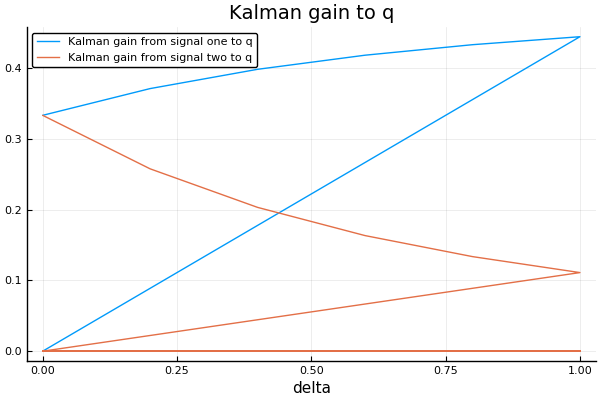

In [59]:
using Plots, LaTeXStrings; pyplot()
plot(deltas, transpose(kalman),
title = "Kalman gain to q",
xlabel = "delta",
label = ["Kalman gain from signal one to q" "Kalman gain from signal two to q"])

In [66]:
size(kalman)

(2, 51)

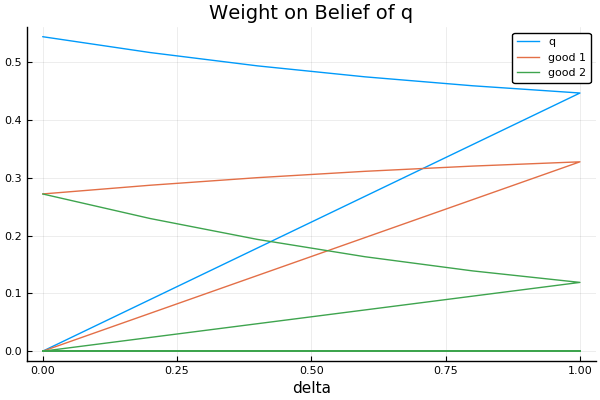

In [60]:
using Plots, LaTeXStrings; pyplot()
plot(deltas, transpose(weights),
title = "Weight on Belief of q",
xlabel = "delta",
label = ["q" "good 1" "good 2"])

In [48]:
size(weights)


(3, 51)

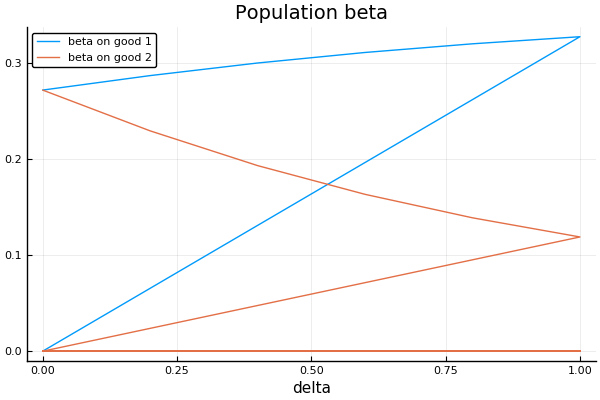

In [63]:
using Plots, LaTeXStrings; pyplot()
plot(deltas, transpose(betas),
title = "Population beta",
xlabel = "delta",
label = ["beta on good 1" "beta on good 2"])

As we can see, the household receives two signals, one about the inflation rate of each good $\pi_{1t}, \pi_{2t}.$ Further, the Kalman gain on the first signal is uniformly increasing in $\delta_{i},$ due to the fact that this is the signal primarily loading on good $2,$ while the other signal loads on good $1.$ Thus, the household is choosing signals that are increasingly informative about $\pi_{2t}$ as $\delta_{i}$ increases. Further, as they choose signals more informative of $\pi_{2t},$ they simultaneously believe their signal of $\pi_{1t}$ is more informative about $q$ and increasingly miss-infer movements in $z_{1t}$ to be movements in $q.$